# [Project 2] 전이학습

____________________

### 프로젝트 목표
- 매우 큰 데이터셋의 특징을 가지고 작은 데이터셋의 전이학습을 통해 성능을 끌어내는 모델 생성 


____________________

### 프로젝트 목차
1. __데이터 읽기__: 전이학습에 사용하고자하는 hymenoptera 데이터 확인<br>


2. __데이터 전 처리__: 딥러닝 모델에 필요한 입력값 형식으로 처리<br>
    2.1. 사용하는 데이터셋의 mean, std값을 사용하여 전처리<br>
    2.2. 데이터 train, valid 나누기<br>


3. __딥러닝 모델 학습__: resnet18 모델을 사용하여 전이 학습 수행<br>
    3.1. fc layer freeze<br>


4. __데이터 생성__: 학습된 모델을 바탕으로 평가 및 예측<br>
    4.1. 생성된 데이터 시각화<br>



____

## 프로젝트 개요

실제로 많은 상황에서 데이터 수집이 어려울 수 있습니다. 딥러닝 모델은 수백만 개의 파라미터를 조정해야 하기 때문에 대규모 데이터가 필요합니다. 하지만 전이학습을 사용하면 사전 훈련된 모델이 이미 다른 큰 데이터셋에서 학습된 지식을 활용하므로 적은 양의 데이터로도 효과적인 모델을 구축할 수 있습니다. 또한 이미 학습된 모델을 기반으로 작업을 시작할 수 있으므로 시간과 비용을 절감할 수 있고, 대규모 데이터셋에서 학습된 상태이기 때문에 일반적으로 높은 성능을 보여주는 경우가 많습니다.

이번 프로젝트에선 pytorch에서 제공하는 hymenoptera_data을 가지고 resnet18에 전이학습을 통해 분류 예측 성능이 높은지 알아봅시다.

____

# Download hymenoptera_data Dataset

In [1]:
import urllib.request
import zipfile
import os

# 다운로드할 파일 URL
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

# 저장할 로컬 파일명
filename = "hymenoptera_data.zip"

# 파일 다운로드
urllib.request.urlretrieve(url, filename)

# 압축 해제
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

# 압축 파일 삭제
os.remove(filename)

In [2]:
# torch, torchvision, numpy, matplotlib, os, copy  등 필요 library를 import 하십시오. 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy

# Load hymenoptera_data Dataset

In [3]:
# train 데이터에는 RandomResizedCrop(224), RandomHorizontalFlip(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# val 데이터에는 Resize(256), CenterCrop(224), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# 사용하여 ToTensor() 형태로 변환하는 transforms을 딕셔너리 만드십시오.

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
# hymenoptera_data 경로를 설정하십시오.
# datasets.ImageFolder(os.path.join(), data_transforms[])를 사용하여 hymenoptera_data의 train, val 데이터를 생성하십시오.
# batch, num_workers는 4로 하고 shuffle=True로 하여 train, val 데이터를 가져오십시오.
# train, val 데이터 크기를 생성하십시오.
# 시각화를 하기 위해 train 데이터의 class를 생성하십시오. 

data_dir = './hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# hymenoptera_data Dataset 학습 데이터 시각화

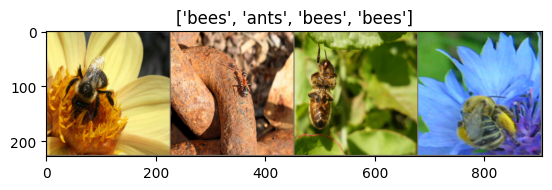

In [5]:
# 학습 데이터 시각화를 위해 img=inp.num# Load hymenoptera_data Datasetpy().transpose((1, 2, 0)) 값과, mean, std 값을 가져와서 std * img + mean을 완성하고 
# np.clip을 사용하여 이미지가 0,1 사이에 있게 한 후, 이미지와 title을 시각화 함수를 생성 하십시오.
# next(iter()) 를 사용하여 dataloaders['train'] 의 이미지 값과 클래스 명을 호출 하십시오.
# torchvision.utils.make_grid()를 사용하여 무작위로 선택된 이미지들을 그리드 형태로 배열하여 하나의 이미지로 합치십시오.
# 함수를 사용하여 시각화 하십시오.

def imshow(inp, title=None):
    img = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 학습 모델 생성

In [6]:
# input으로 model, loss function, opitmizer, scheduler, epochs을 받는 함수를 구성하십시오.
# copy.deepcopy(model.state_dict())를 사용하여 가장 높은 정확도를 달성한 경우 모델 가중치를 복사하여 저장하십시오.
# train, val에 따라 model.train(), model.eval()을 사용하십시오.
# dataloaders['train'], dataloaders['val']을 사용하여 이미지 값과 클래스명을 inputs.to('cpu')로 생성하십시오.
# optimizer.zero_grad()를 사용하여 초기화 하십시오.
# with torch.set_grad_enabled() 사용하여 순전파는 torch.max()를 통해 계산하고 선언한 loss function을 통해 loss를 구하십시오.
# 역전파로 train일때 그래디언트를 계속하도록 활성화 하십시오.
#  loss.item()을 사용하여 현재 미니배치에서의 손실 값을 가져온 뒤, 
# 미니배치의 크기 inputs.size(0)와 곱하여 running_loss에 누적 함으로써 전체 데이터셋에 대한 총 손실값을 계산하십시오.
# epoch loss 와 epch 계산된 평군 저항과 평균 손실을 구하십시오

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):

    # deepcopy 생성
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # epoch만큼 반복문 생성
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model
 

# 검증 모델 생성

In [7]:
# was_training = model.training를 사용하여 현재 모델의 학습 모드를 저장하십시오.
# model.eval()을 사용하여 모델을 평가 모드로 전환하십시오.
# images_so_far = 0: 시각화한 이미지의 수를 저장하는 변수입니다.
# with torch.no_grad() 예측 과정에서 그래디언트를 계산하지 않도록 사용하고, 
# dataloaders['val'] 검증 데이터로부터 미니배치를 순회하면서 예측 결과를 시각화하십시오.
# inputs = inputs.to(device), labels = labels.to(device) 학습할 때와 마찬가지로 디바이스를  이동하십시오.
# _, preds = torch.max(outputs, 1): torch.max() 함수를 사용하여 예측된 클래스를 구하십시오.
# for j in range(inputs.size()[0]):: 미니배치의 각 샘플에 대해 반복하면서 예측 결과를 시각화하고, 함수를 호출하기 전의 모델의 상태로 되돌리십시오.


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 전이학습 준비

In [8]:
# device ='cpu'를 사용하십시오
# model을 resnet18에 pretrained=True를 사용하여 생성하십시오.
# 다운받은 resnet18 model의 network를 print하고
# fc 레이어를 제외한 나머지 모든 parameter를 동결하세요.

device = 'cpu' 
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.fc.parameters():
    param.requires_grad = True

for name, param in model_ft.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')


C:\python\lesson\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\python\lesson\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer2.0.conv1.weight: requires_grad=False
layer2.0.bn1.weight: requires_grad=False
layer2.0.bn1.bias: requires_grad=False
layer2.0.conv2.weight: requires_grad=False
layer2.0.bn2.weight: requires_grad=False
layer2.0.bn2.bias: requires_grad=False
layer2.0.downsample.0.weight: requires_grad=False
layer2.0.downsample.1.weight: requires_grad=False
layer2.0.downsample.1.bias: requires_grad=False
layer2.1.conv1.wei

# 손실함수, optimizer, 스케줄러를 생성하십시오.

In [11]:
# nn.CrossEntropyLoss()로 손실 함수를 사용하십시오.
# optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)로 모든 파라미터를 최적화하는 SGD 옵티마이저를 생성하고 
# lr은 0.001로 설정되고, momentum은 0.9로 설정하십시오
# lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)로 학습률을 7 에폭마다 0.1씩 감소시키는 스케줄러를 생성하십시오.

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 학습 진행

In [12]:
# 위에서 생성한 학습 함수에 input값을 넣고 학습을 진행하십시오.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5969 Acc: 0.6926
val Loss: 0.3166 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.4235 Acc: 0.8156
val Loss: 0.3513 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.4267 Acc: 0.7951
val Loss: 0.4032 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4072 Acc: 0.8033
val Loss: 0.1868 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.3609 Acc: 0.8197
val Loss: 0.1868 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3620 Acc: 0.8484
val Loss: 0.1999 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4126 Acc: 0.8238
val Loss: 0.1888 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.2577 Acc: 0.8975
val Loss: 0.1955 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2823 Acc: 0.8730
val Loss: 0.2145 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2996 Acc: 0.8566
val Loss: 0.2192 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3359 Acc: 0.8361
val Loss: 0.1958 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3456 Acc: 0.8156
val Loss: 0.2054 Acc: 0.9346

Ep

# 검증 시각화 진행

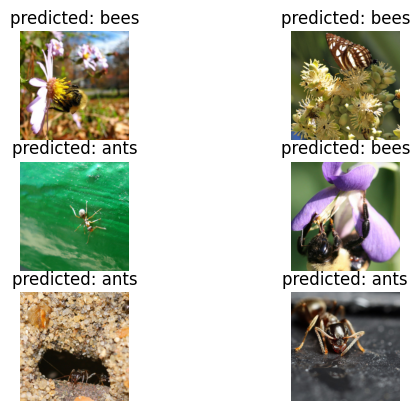

In [13]:
# 위에서 생성한 검증 함수에 input값을 넣고 검증 시각화를 진행하십시오.
visualize_model(model_ft)